In [1]:
import seaborn as sns
from main import preprocess

In [2]:
df, df_small, source = preprocess(0, 16)

In [3]:
df.iloc[0]

age               0.301370
workclass         0.625000
education-num     0.800000
capital-gain      0.021740
capital-loss      0.000000
hours-per-week    0.397959
50K               0.000000
Name: 0, dtype: float64

In [5]:
df_small.iloc[source]

age               0.369442
workclass         0.519065
education-num     0.837474
capital-gain      0.012196
capital-loss      0.017323
hours-per-week    0.445603
50K               1.000000
Name: 9, dtype: float64

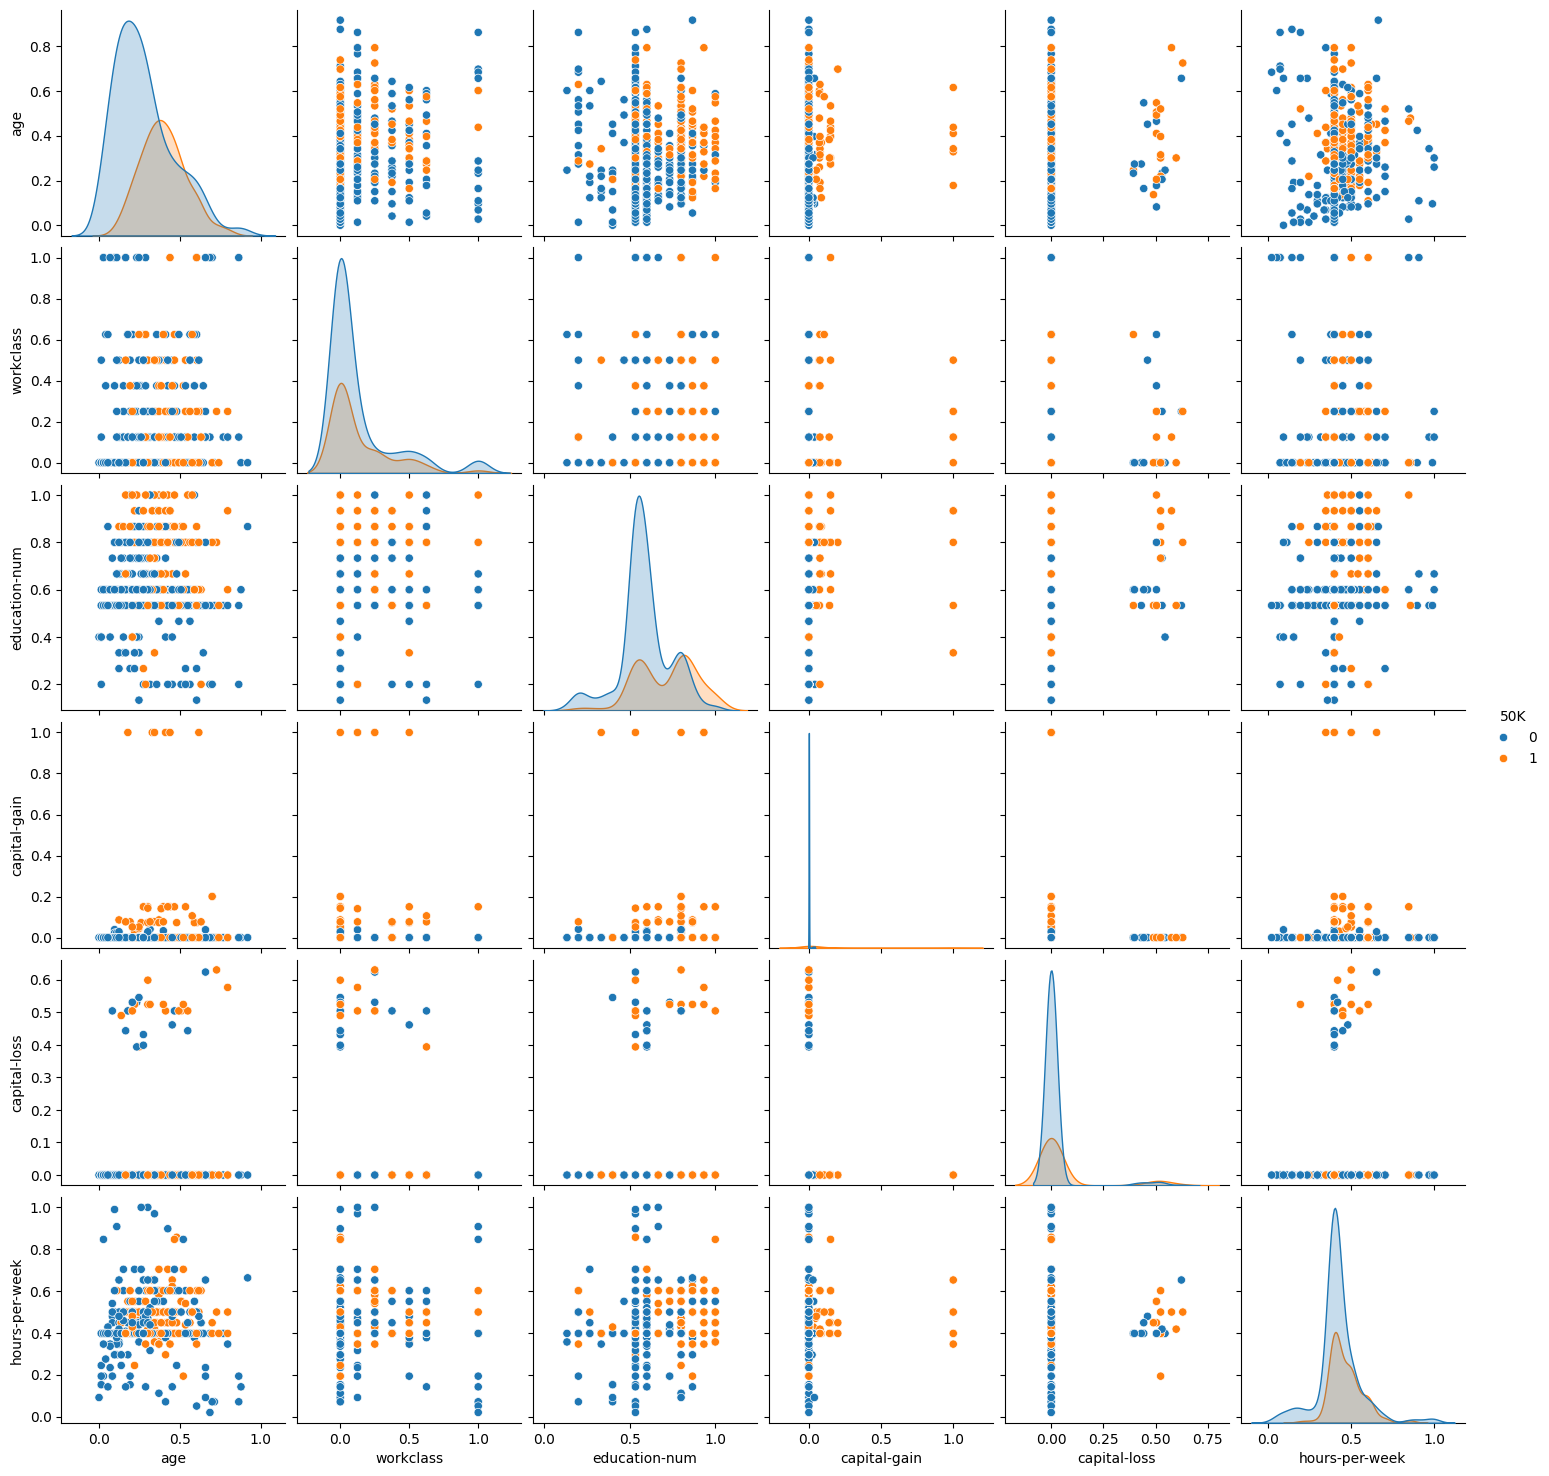

In [5]:
sns.pairplot(df.sample(512), hue="50K")

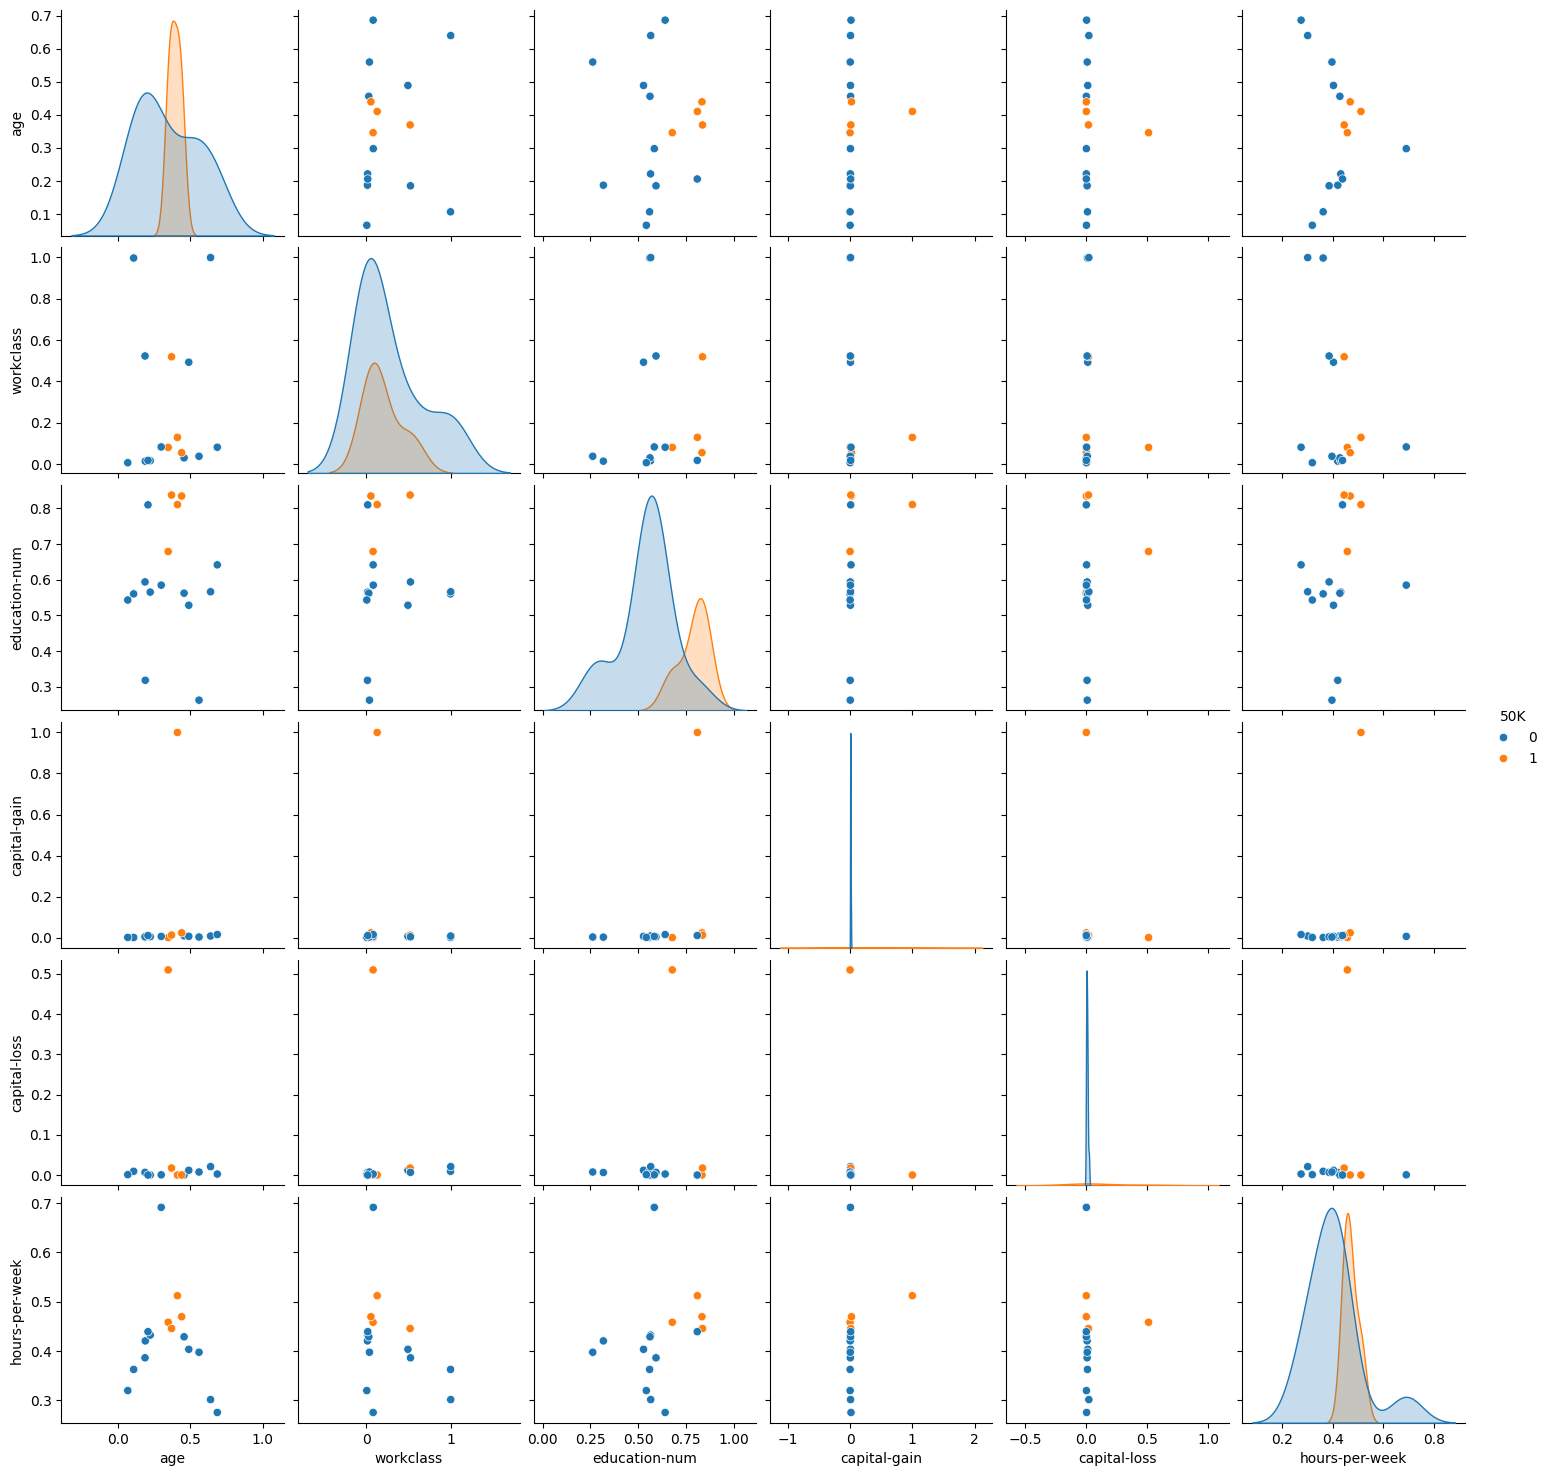

In [6]:
sns.pairplot(df_small, hue="50K")

In [6]:
df.describe()

,age,workclass,education-num,capital-gain,capital-loss,hours-per-week,50K
count,17653.000000,17653.000000,17653.000000,17653.000000,17653.000000,17653.000000,17653.000000
mean,0.312178,0.133901,0.617666,0.014086,0.027814,0.425856,0.325157
std,0.184411,0.256048,0.165146,0.086013,0.116493,0.125438,0.468447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.164384,0.000000,0.533333,0.000000,0.000000,0.397959,0.000000
50%,0.287671,0.000000,0.600000,0.000000,0.000000,0.397959,0.000000
75%,0.438356,0.125000,0.800000,0.000000,0.000000,0.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df_small.describe()

,age,workclass,education-num,capital-gain,capital-loss,hours-per-week,50K
count,16.000000,16.000000,16.000000,1.600000e+01,1.600000e+01,16.000000,16.000000
mean,0.354135,0.255202,0.605983,6.896060e-02,3.711961e-02,0.421498,0.250000
std,0.185700,0.344265,0.166413,2.483505e-01,1.262378e-01,0.095699,0.447214
min,0.065865,0.006681,0.261941,-8.673617e-17,-2.081668e-17,0.275399,0.000000
25%,0.201232,0.027118,0.555808,2.666417e-03,1.283312e-04,0.380334,0.000000
50%,0.357727,0.081186,0.575345,6.085203e-03,4.386048e-03,0.424648,0.000000
75%,0.464325,0.499354,0.711730,1.054119e-02,9.915623e-03,0.448774,0.250000
max,0.686526,0.998826,0.837474,1.000000e+00,5.098772e-01,0.691210,1.000000


In [8]:
from algo import recourse


In [9]:
graph, dists = recourse(df_small, 4, source, limit=100000)
dists

[[(1, 0.0, 1.7379885388877256),
  (12, 0.12128588728230214, 1.7243207666410743),
  (12, 1.1212858872823022, 0.4990557082791149),
  (1, 2.0, 0.4935011309937297)],
 [(2, 0.002935950461769421, 1.756656333090072),
  (12, 0.1555025367835982, 1.7337555336177302),
  (2, 1.0029359504617694, 0.7224396835887759),
  (12, 1.1555025367835983, 0.5084904752557708)],
 [(1, 0.23475227474727983, 1.7597359495142695),
  (12, 0.39025481153087804, 1.7460664229836653),
  (15, 1.2501933773145786, 0.7507372570664612),
  (0, 1.268968924248576, 0.5217471199903159),
  (12, 1.3902548115308782, 0.5208013646217059),
  (1, 2.23475227474728, 0.5152485416202734)],
 [(14, 2.411193076011513, 0.9286232751005943),
  (9, 9.119499832022885, 0.5137461708627914)],
 [(8, 4.0, 8.900509434382911),
  (10, 4.4737849864355175, 8.87424375692399),
  (10, 8.473784986435517, 4.823088324935173)],
 [],
 [],
 [(2, 0.2725541443920735, 1.7953712456830466),
  (15, 1.233438766002865, 0.7771328333698553),
  (2, 1.2725541443920734, 0.76115459618

In [12]:
from sklearn.decomposition import PCA

pca = PCA(2)
coord = pca.fit_transform(df_small.drop(columns=["50K"]))
coord

,pca0,pca1
0,-0.228213,-0.215898
1,-0.229507,-0.123337
2,-0.206227,-0.087440
3,0.252095,-0.031298
4,0.735343,-0.005764
5,-0.182765,-0.082165
6,-0.272946,0.918906
7,-0.192664,0.023585
8,0.764779,0.068728
9,0.263041,0.070654


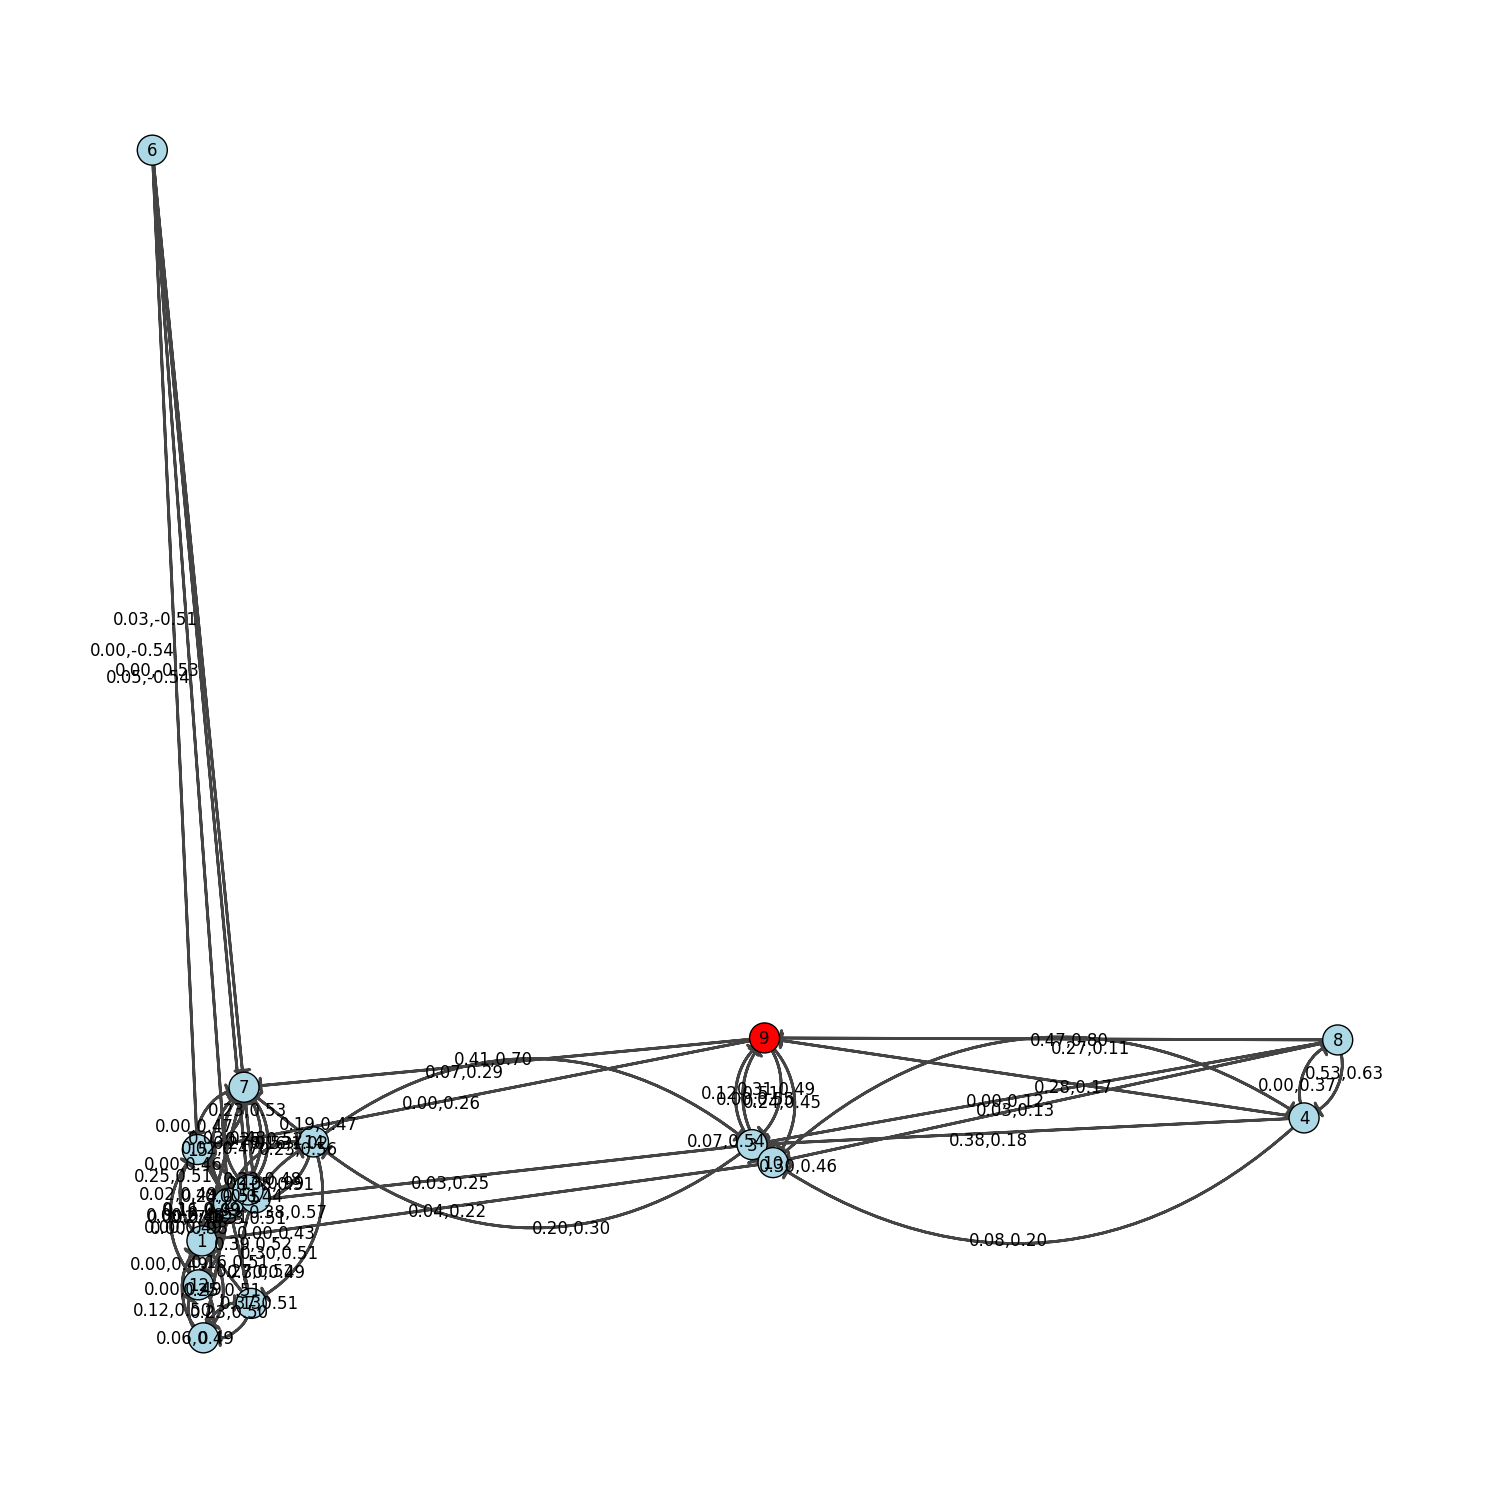

In [23]:
import igraph as ig
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15), layout="tight")
ig.plot(
    graph,
    ax,
    layout=coord.to_numpy().tolist(),
    edge_arrow_size=2,
    vertex_label=graph.vs.indices,
    vertex_color=["red" if i == source else "lightblue" for i in range(graph.vcount())],
    edge_label=[f"{a:.2f},{b:.2f}" for a, b in graph.es["cost"]],
)
plt.show()
